In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-15 12:46:31.889698: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-15 12:46:31.889776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-15 12:46:31.889783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "funnel")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.sigma = 1.25
    config.model.sigma_base = 1.75
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
config.trainer.learning_rate = 5 * 10**(-3)
config.trainer.lr_sch_base_dec = 0.95 # For funnel
config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 6000
config.trainer.learning_rate = 1 * 10**(-5)

In [3]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

if config.model.reference_process_key == "oudstl":
    config.model.sigma_base = config.model.sigma

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma_base * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [4]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7f8824b7b400>, apply=<function transform_with_state.<locals>.apply_fn at 0x7f8824b7b5b0>)


In [5]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [6]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 2.2203123569488525)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 2.2190730571746826)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 2.28922438621521)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 2.556382894515991)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 2.3658061027526855)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 2.1995949745178223)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 2.189080238342285)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 2.841245174407959)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 2.7316572666168213)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 2.4264049530029297)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 2.4702205657958984)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 2.3733150959014893)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 2.365818977355957)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 2.2311511039733887)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 3.005653142929077)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 2.290828227996826)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 2.4456069469451904

('epoch: %s %s  loss: %s', 137, 'TRAIN', 2.0757007598876953)
('epoch: %s %s  loss: %s', 138, 'TRAIN', 2.1495089530944824)
('epoch: %s %s  loss: %s', 139, 'TRAIN', 1.971279501914978)
('epoch: %s %s  loss: %s', 140, 'TRAIN', 2.2879865169525146)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 2.243928909301758)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 2.0729827880859375)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 2.200532913208008)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 2.0905416011810303)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 2.2333667278289795)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 2.0435235500335693)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 2.2227025032043457)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 2.054783821105957)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 2.5133535861968994)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 1.9866793155670166)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 1.9932832717895508)
('epoch: %s %s  loss: %s', 152, 'TRAIN', 2.4719297885894775)
('epoch: %s %s  loss: %s', 1

('epoch: %s %s  loss: %s', 273, 'TRAIN', 2.042889356613159)
('epoch: %s %s  loss: %s', 274, 'TRAIN', 1.81794011592865)
('epoch: %s %s  loss: %s', 275, 'TRAIN', 1.8747271299362183)
('epoch: %s %s  loss: %s', 276, 'TRAIN', 2.2953221797943115)
('epoch: %s %s  loss: %s', 277, 'TRAIN', 2.2629573345184326)
('epoch: %s %s  loss: %s', 278, 'TRAIN', 1.8397748470306396)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 1.7759442329406738)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 2.1963584423065186)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 1.9340472221374512)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 2.3185431957244873)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 1.8256484270095825)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 1.916399598121643)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 2.0633203983306885)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 1.7852678298950195)
('epoch: %s %s  loss: %s', 287, 'TRAIN', 1.8648275136947632)
('epoch: %s %s  loss: %s', 288, 'TRAIN', 1.8316078186035156)
('epoch: %s %s  loss: %s', 2

('epoch: %s %s  loss: %s', 408, 'TRAIN', 2.0552148818969727)
('epoch: %s %s  loss: %s', 409, 'TRAIN', 1.7269891500473022)
('epoch: %s %s  loss: %s', 410, 'TRAIN', 2.048950433731079)
('epoch: %s %s  loss: %s', 411, 'TRAIN', 1.6426807641983032)
('epoch: %s %s  loss: %s', 412, 'TRAIN', 1.8309540748596191)
('epoch: %s %s  loss: %s', 413, 'TRAIN', 1.817094087600708)
('epoch: %s %s  loss: %s', 414, 'TRAIN', 1.6654289960861206)
('epoch: %s %s  loss: %s', 415, 'TRAIN', 1.6474038362503052)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 2.423628568649292)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 1.7460867166519165)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 1.7544666528701782)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 1.627936601638794)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 1.7876542806625366)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 1.714354157447815)
('epoch: %s %s  loss: %s', 422, 'TRAIN', 1.7171664237976074)
('epoch: %s %s  loss: %s', 423, 'TRAIN', 2.1344752311706543)
('epoch: %s %s  loss: %s', 42

('epoch: %s %s  loss: %s', 543, 'TRAIN', 1.6402922868728638)
('epoch: %s %s  loss: %s', 544, 'TRAIN', 1.6490904092788696)
('epoch: %s %s  loss: %s', 545, 'TRAIN', 1.7200498580932617)
('epoch: %s %s  loss: %s', 546, 'TRAIN', 1.8111671209335327)
('epoch: %s %s  loss: %s', 547, 'TRAIN', 1.608652949333191)
('epoch: %s %s  loss: %s', 548, 'TRAIN', 1.7537331581115723)
('epoch: %s %s  loss: %s', 549, 'TRAIN', 1.5710469484329224)
('epoch: %s %s  loss: %s', 550, 'TRAIN', 1.7039273977279663)
('epoch: %s %s  loss: %s', 551, 'TRAIN', 1.6320024728775024)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 1.8424875736236572)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 1.585925579071045)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 1.606432318687439)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 1.6757283210754395)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 1.8148980140686035)
('epoch: %s %s  loss: %s', 557, 'TRAIN', 1.6919735670089722)
('epoch: %s %s  loss: %s', 558, 'TRAIN', 1.590582013130188)
('epoch: %s %s  loss: %s', 5

('epoch: %s %s  loss: %s', 678, 'TRAIN', 1.6127207279205322)
('epoch: %s %s  loss: %s', 679, 'TRAIN', 1.5739173889160156)
('epoch: %s %s  loss: %s', 680, 'TRAIN', 1.5127642154693604)
('epoch: %s %s  loss: %s', 681, 'TRAIN', 1.5721479654312134)
('epoch: %s %s  loss: %s', 682, 'TRAIN', 1.7690593004226685)
('epoch: %s %s  loss: %s', 683, 'TRAIN', 1.9958455562591553)
('epoch: %s %s  loss: %s', 684, 'TRAIN', 1.68192458152771)
('epoch: %s %s  loss: %s', 685, 'TRAIN', 1.555441975593567)
('epoch: %s %s  loss: %s', 686, 'TRAIN', 1.557920217514038)
('epoch: %s %s  loss: %s', 687, 'TRAIN', 1.6318424940109253)
('epoch: %s %s  loss: %s', 688, 'TRAIN', 1.547236442565918)
('epoch: %s %s  loss: %s', 689, 'TRAIN', 1.6499539613723755)
('epoch: %s %s  loss: %s', 690, 'TRAIN', 1.6512118577957153)
('epoch: %s %s  loss: %s', 691, 'TRAIN', 1.9165101051330566)
('epoch: %s %s  loss: %s', 692, 'TRAIN', 1.5734076499938965)
('epoch: %s %s  loss: %s', 693, 'TRAIN', 1.5815404653549194)
('epoch: %s %s  loss: %s', 69

('epoch: %s %s  loss: %s', 813, 'TRAIN', 1.6214377880096436)
('epoch: %s %s  loss: %s', 814, 'TRAIN', 1.5090622901916504)
('epoch: %s %s  loss: %s', 815, 'TRAIN', 1.6057813167572021)
('epoch: %s %s  loss: %s', 816, 'TRAIN', 1.5692722797393799)
('epoch: %s %s  loss: %s', 817, 'TRAIN', 1.5533301830291748)
('epoch: %s %s  loss: %s', 818, 'TRAIN', 1.6933655738830566)
('epoch: %s %s  loss: %s', 819, 'TRAIN', 1.570454716682434)
('epoch: %s %s  loss: %s', 820, 'TRAIN', 1.956167459487915)
('epoch: %s %s  loss: %s', 821, 'TRAIN', 1.6316338777542114)
('epoch: %s %s  loss: %s', 822, 'TRAIN', 2.1124770641326904)
('epoch: %s %s  loss: %s', 823, 'TRAIN', 1.5148543119430542)
('epoch: %s %s  loss: %s', 824, 'TRAIN', 1.6594206094741821)
('epoch: %s %s  loss: %s', 825, 'TRAIN', 1.55307936668396)
('epoch: %s %s  loss: %s', 826, 'TRAIN', 1.5818110704421997)
('epoch: %s %s  loss: %s', 827, 'TRAIN', 1.6725683212280273)
('epoch: %s %s  loss: %s', 828, 'TRAIN', 1.6332387924194336)
('epoch: %s %s  loss: %s', 8

('epoch: %s %s  loss: %s', 948, 'TRAIN', 1.5992776155471802)
('epoch: %s %s  loss: %s', 949, 'TRAIN', 1.5501658916473389)
('epoch: %s %s  loss: %s', 950, 'TRAIN', 1.5907992124557495)
('epoch: %s %s  loss: %s', 951, 'TRAIN', 1.5824986696243286)
('epoch: %s %s  loss: %s', 952, 'TRAIN', 1.5642240047454834)
('epoch: %s %s  loss: %s', 953, 'TRAIN', 1.4976013898849487)
('epoch: %s %s  loss: %s', 954, 'TRAIN', 1.5472235679626465)
('epoch: %s %s  loss: %s', 955, 'TRAIN', 1.5520272254943848)
('epoch: %s %s  loss: %s', 956, 'TRAIN', 1.5314621925354004)
('epoch: %s %s  loss: %s', 957, 'TRAIN', 1.5640267133712769)
('epoch: %s %s  loss: %s', 958, 'TRAIN', 1.6359477043151855)
('epoch: %s %s  loss: %s', 959, 'TRAIN', 1.5220671892166138)
('epoch: %s %s  loss: %s', 960, 'TRAIN', 1.6983094215393066)
('epoch: %s %s  loss: %s', 961, 'TRAIN', 1.5836517810821533)
('epoch: %s %s  loss: %s', 962, 'TRAIN', 1.5628788471221924)
('epoch: %s %s  loss: %s', 963, 'TRAIN', 1.79481041431427)
('epoch: %s %s  loss: %s',

('epoch: %s %s  loss: %s', 1082, 'TRAIN', 1.579256534576416)
('epoch: %s %s  loss: %s', 1083, 'TRAIN', 1.5289462804794312)
('epoch: %s %s  loss: %s', 1084, 'TRAIN', 1.5492911338806152)
('epoch: %s %s  loss: %s', 1085, 'TRAIN', 1.6885974407196045)
('epoch: %s %s  loss: %s', 1086, 'TRAIN', 1.5459709167480469)
('epoch: %s %s  loss: %s', 1087, 'TRAIN', 1.5419518947601318)
('epoch: %s %s  loss: %s', 1088, 'TRAIN', 1.64143967628479)
('epoch: %s %s  loss: %s', 1089, 'TRAIN', 1.5373777151107788)
('epoch: %s %s  loss: %s', 1090, 'TRAIN', 1.5745925903320312)
('epoch: %s %s  loss: %s', 1091, 'TRAIN', 1.5647333860397339)
('epoch: %s %s  loss: %s', 1092, 'TRAIN', 1.5532715320587158)
('epoch: %s %s  loss: %s', 1093, 'TRAIN', 1.549142837524414)
('epoch: %s %s  loss: %s', 1094, 'TRAIN', 1.5391790866851807)
('epoch: %s %s  loss: %s', 1095, 'TRAIN', 1.4657217264175415)
('epoch: %s %s  loss: %s', 1096, 'TRAIN', 1.5913840532302856)
('epoch: %s %s  loss: %s', 1097, 'TRAIN', 1.6591545343399048)
('epoch: %s 

('epoch: %s %s  loss: %s', 1215, 'TRAIN', 1.5411872863769531)
('epoch: %s %s  loss: %s', 1216, 'TRAIN', 1.5179600715637207)
('epoch: %s %s  loss: %s', 1217, 'TRAIN', 1.5680952072143555)
('epoch: %s %s  loss: %s', 1218, 'TRAIN', 1.5734844207763672)
('epoch: %s %s  loss: %s', 1219, 'TRAIN', 1.7539677619934082)
('epoch: %s %s  loss: %s', 1220, 'TRAIN', 1.6661512851715088)
('epoch: %s %s  loss: %s', 1221, 'TRAIN', 1.616837739944458)
('epoch: %s %s  loss: %s', 1222, 'TRAIN', 1.5724587440490723)
('epoch: %s %s  loss: %s', 1223, 'TRAIN', 1.6623049974441528)
('epoch: %s %s  loss: %s', 1224, 'TRAIN', 1.5423657894134521)
('epoch: %s %s  loss: %s', 1225, 'TRAIN', 1.5056456327438354)
('epoch: %s %s  loss: %s', 1226, 'TRAIN', 1.5476551055908203)
('epoch: %s %s  loss: %s', 1227, 'TRAIN', 1.4979523420333862)
('epoch: %s %s  loss: %s', 1228, 'TRAIN', 1.6002928018569946)
('epoch: %s %s  loss: %s', 1229, 'TRAIN', 2.0317296981811523)
('epoch: %s %s  loss: %s', 1230, 'TRAIN', 1.5791901350021362)
('epoch: 

('epoch: %s %s  loss: %s', 1348, 'TRAIN', 1.58780038356781)
('epoch: %s %s  loss: %s', 1349, 'TRAIN', 1.7712950706481934)
('epoch: %s %s  loss: %s', 1350, 'TRAIN', 1.5381075143814087)
('epoch: %s %s  loss: %s', 1351, 'TRAIN', 1.536576271057129)
('epoch: %s %s  loss: %s', 1352, 'TRAIN', 1.6419998407363892)
('epoch: %s %s  loss: %s', 1353, 'TRAIN', 1.5767571926116943)
('epoch: %s %s  loss: %s', 1354, 'TRAIN', 1.5926131010055542)
('epoch: %s %s  loss: %s', 1355, 'TRAIN', 1.6602654457092285)
('epoch: %s %s  loss: %s', 1356, 'TRAIN', 1.5448323488235474)
('epoch: %s %s  loss: %s', 1357, 'TRAIN', 1.512891173362732)
('epoch: %s %s  loss: %s', 1358, 'TRAIN', 1.5187510251998901)
('epoch: %s %s  loss: %s', 1359, 'TRAIN', 1.9973483085632324)
('epoch: %s %s  loss: %s', 1360, 'TRAIN', 1.6180484294891357)
('epoch: %s %s  loss: %s', 1361, 'TRAIN', 1.6157749891281128)
('epoch: %s %s  loss: %s', 1362, 'TRAIN', 1.58375883102417)
('epoch: %s %s  loss: %s', 1363, 'TRAIN', 1.5815664529800415)
('epoch: %s %s

('epoch: %s %s  loss: %s', 1481, 'TRAIN', 1.5405700206756592)
('epoch: %s %s  loss: %s', 1482, 'TRAIN', 1.5522149801254272)
('epoch: %s %s  loss: %s', 1483, 'TRAIN', 1.5281225442886353)
('epoch: %s %s  loss: %s', 1484, 'TRAIN', 1.6391206979751587)
('epoch: %s %s  loss: %s', 1485, 'TRAIN', 1.485862374305725)
('epoch: %s %s  loss: %s', 1486, 'TRAIN', 1.5889393091201782)
('epoch: %s %s  loss: %s', 1487, 'TRAIN', 1.5430055856704712)
('epoch: %s %s  loss: %s', 1488, 'TRAIN', 1.5964981317520142)
('epoch: %s %s  loss: %s', 1489, 'TRAIN', 1.6170681715011597)
('epoch: %s %s  loss: %s', 1490, 'TRAIN', 1.5789501667022705)
('epoch: %s %s  loss: %s', 1491, 'TRAIN', 1.545310139656067)
('epoch: %s %s  loss: %s', 1492, 'TRAIN', 1.5873020887374878)
('epoch: %s %s  loss: %s', 1493, 'TRAIN', 1.5928988456726074)
('epoch: %s %s  loss: %s', 1494, 'TRAIN', 1.5575238466262817)
('epoch: %s %s  loss: %s', 1495, 'TRAIN', 1.5766680240631104)
('epoch: %s %s  loss: %s', 1496, 'TRAIN', 1.5699827671051025)
('epoch: %

('epoch: %s %s  loss: %s', 1614, 'TRAIN', 1.521191954612732)
('epoch: %s %s  loss: %s', 1615, 'TRAIN', 1.6216837167739868)
('epoch: %s %s  loss: %s', 1616, 'TRAIN', 1.5544413328170776)
('epoch: %s %s  loss: %s', 1617, 'TRAIN', 1.678423285484314)
('epoch: %s %s  loss: %s', 1618, 'TRAIN', 1.6239622831344604)
('epoch: %s %s  loss: %s', 1619, 'TRAIN', 1.5726685523986816)
('epoch: %s %s  loss: %s', 1620, 'TRAIN', 1.5903266668319702)
('epoch: %s %s  loss: %s', 1621, 'TRAIN', 1.787861704826355)
('epoch: %s %s  loss: %s', 1622, 'TRAIN', 1.6061753034591675)
('epoch: %s %s  loss: %s', 1623, 'TRAIN', 1.5225685834884644)
('epoch: %s %s  loss: %s', 1624, 'TRAIN', 1.5316522121429443)
('epoch: %s %s  loss: %s', 1625, 'TRAIN', 1.5390745401382446)
('epoch: %s %s  loss: %s', 1626, 'TRAIN', 1.59709632396698)
('epoch: %s %s  loss: %s', 1627, 'TRAIN', 1.7138149738311768)
('epoch: %s %s  loss: %s', 1628, 'TRAIN', 1.60257089138031)
('epoch: %s %s  loss: %s', 1629, 'TRAIN', 1.5646913051605225)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 1747, 'TRAIN', 1.629270076751709)
('epoch: %s %s  loss: %s', 1748, 'TRAIN', 1.5789248943328857)
('epoch: %s %s  loss: %s', 1749, 'TRAIN', 1.559460997581482)
('epoch: %s %s  loss: %s', 1750, 'TRAIN', 1.6020700931549072)
('epoch: %s %s  loss: %s', 1751, 'TRAIN', 1.5599913597106934)
('epoch: %s %s  loss: %s', 1752, 'TRAIN', 1.621256709098816)
('epoch: %s %s  loss: %s', 1753, 'TRAIN', 1.6287086009979248)
('epoch: %s %s  loss: %s', 1754, 'TRAIN', 1.5756736993789673)
('epoch: %s %s  loss: %s', 1755, 'TRAIN', 1.523177146911621)
('epoch: %s %s  loss: %s', 1756, 'TRAIN', 1.505264401435852)
('epoch: %s %s  loss: %s', 1757, 'TRAIN', 1.5604121685028076)
('epoch: %s %s  loss: %s', 1758, 'TRAIN', 1.5722119808197021)
('epoch: %s %s  loss: %s', 1759, 'TRAIN', 1.5742099285125732)
('epoch: %s %s  loss: %s', 1760, 'TRAIN', 1.5267119407653809)
('epoch: %s %s  loss: %s', 1761, 'TRAIN', 1.4954336881637573)
('epoch: %s %s  loss: %s', 1762, 'TRAIN', 1.5318206548690796)
('epoch: %s %

('epoch: %s %s  loss: %s', 1880, 'TRAIN', 2.033846616744995)
('epoch: %s %s  loss: %s', 1881, 'TRAIN', 1.5804574489593506)
('epoch: %s %s  loss: %s', 1882, 'TRAIN', 1.4740079641342163)
('epoch: %s %s  loss: %s', 1883, 'TRAIN', 1.5541856288909912)
('epoch: %s %s  loss: %s', 1884, 'TRAIN', 1.5525398254394531)
('epoch: %s %s  loss: %s', 1885, 'TRAIN', 1.5865553617477417)
('epoch: %s %s  loss: %s', 1886, 'TRAIN', 1.555012583732605)
('epoch: %s %s  loss: %s', 1887, 'TRAIN', 1.5932927131652832)
('epoch: %s %s  loss: %s', 1888, 'TRAIN', 1.6583009958267212)
('epoch: %s %s  loss: %s', 1889, 'TRAIN', 1.5546045303344727)
('epoch: %s %s  loss: %s', 1890, 'TRAIN', 1.5862982273101807)
('epoch: %s %s  loss: %s', 1891, 'TRAIN', 1.5848416090011597)
('epoch: %s %s  loss: %s', 1892, 'TRAIN', 1.5050121545791626)
('epoch: %s %s  loss: %s', 1893, 'TRAIN', 1.591086983680725)
('epoch: %s %s  loss: %s', 1894, 'TRAIN', 1.4955382347106934)
('epoch: %s %s  loss: %s', 1895, 'TRAIN', 1.5233546495437622)
('epoch: %s

('epoch: %s %s  loss: %s', 2013, 'TRAIN', 1.538644552230835)
('epoch: %s %s  loss: %s', 2014, 'TRAIN', 1.7060474157333374)
('epoch: %s %s  loss: %s', 2015, 'TRAIN', 1.4981917142868042)
('epoch: %s %s  loss: %s', 2016, 'TRAIN', 1.6274564266204834)
('epoch: %s %s  loss: %s', 2017, 'TRAIN', 1.6943516731262207)
('epoch: %s %s  loss: %s', 2018, 'TRAIN', 1.5207494497299194)
('epoch: %s %s  loss: %s', 2019, 'TRAIN', 1.5326285362243652)
('epoch: %s %s  loss: %s', 2020, 'TRAIN', 1.5744158029556274)
('epoch: %s %s  loss: %s', 2021, 'TRAIN', 1.537003517150879)
('epoch: %s %s  loss: %s', 2022, 'TRAIN', 1.593865990638733)
('epoch: %s %s  loss: %s', 2023, 'TRAIN', 1.596983790397644)
('epoch: %s %s  loss: %s', 2024, 'TRAIN', 1.5520915985107422)
('epoch: %s %s  loss: %s', 2025, 'TRAIN', 1.5877903699874878)
('epoch: %s %s  loss: %s', 2026, 'TRAIN', 1.5380744934082031)
('epoch: %s %s  loss: %s', 2027, 'TRAIN', 1.6867088079452515)
('epoch: %s %s  loss: %s', 2028, 'TRAIN', 1.8702560663223267)
('epoch: %s 

('epoch: %s %s  loss: %s', 2146, 'TRAIN', 1.557887315750122)
('epoch: %s %s  loss: %s', 2147, 'TRAIN', 1.5283799171447754)
('epoch: %s %s  loss: %s', 2148, 'TRAIN', 1.6291208267211914)
('epoch: %s %s  loss: %s', 2149, 'TRAIN', 1.638506531715393)
('epoch: %s %s  loss: %s', 2150, 'TRAIN', 1.5171078443527222)
('epoch: %s %s  loss: %s', 2151, 'TRAIN', 1.5677483081817627)
('epoch: %s %s  loss: %s', 2152, 'TRAIN', 1.5880160331726074)
('epoch: %s %s  loss: %s', 2153, 'TRAIN', 1.5510203838348389)
('epoch: %s %s  loss: %s', 2154, 'TRAIN', 1.6602156162261963)
('epoch: %s %s  loss: %s', 2155, 'TRAIN', 1.5562902688980103)
('epoch: %s %s  loss: %s', 2156, 'TRAIN', 1.5124294757843018)
('epoch: %s %s  loss: %s', 2157, 'TRAIN', 1.6185872554779053)
('epoch: %s %s  loss: %s', 2158, 'TRAIN', 1.5473906993865967)
('epoch: %s %s  loss: %s', 2159, 'TRAIN', 1.556610345840454)
('epoch: %s %s  loss: %s', 2160, 'TRAIN', 1.541481614112854)
('epoch: %s %s  loss: %s', 2161, 'TRAIN', 1.533724069595337)
('epoch: %s %

('epoch: %s %s  loss: %s', 2279, 'TRAIN', 1.6178680658340454)
('epoch: %s %s  loss: %s', 2280, 'TRAIN', 1.5317388772964478)
('epoch: %s %s  loss: %s', 2281, 'TRAIN', 1.5539298057556152)
('epoch: %s %s  loss: %s', 2282, 'TRAIN', 1.5632349252700806)
('epoch: %s %s  loss: %s', 2283, 'TRAIN', 1.552180528640747)
('epoch: %s %s  loss: %s', 2284, 'TRAIN', 1.5272353887557983)
('epoch: %s %s  loss: %s', 2285, 'TRAIN', 1.5590884685516357)
('epoch: %s %s  loss: %s', 2286, 'TRAIN', 1.575618863105774)
('epoch: %s %s  loss: %s', 2287, 'TRAIN', 1.5069959163665771)
('epoch: %s %s  loss: %s', 2288, 'TRAIN', 1.5951875448226929)
('epoch: %s %s  loss: %s', 2289, 'TRAIN', 1.6106499433517456)
('epoch: %s %s  loss: %s', 2290, 'TRAIN', 1.6192606687545776)
('epoch: %s %s  loss: %s', 2291, 'TRAIN', 1.5926264524459839)
('epoch: %s %s  loss: %s', 2292, 'TRAIN', 1.5848078727722168)
('epoch: %s %s  loss: %s', 2293, 'TRAIN', 1.6165434122085571)
('epoch: %s %s  loss: %s', 2294, 'TRAIN', 1.5898478031158447)
('epoch: %

('epoch: %s %s  loss: %s', 2412, 'TRAIN', 1.627234935760498)
('epoch: %s %s  loss: %s', 2413, 'TRAIN', 1.6482996940612793)
('epoch: %s %s  loss: %s', 2414, 'TRAIN', 1.6524653434753418)
('epoch: %s %s  loss: %s', 2415, 'TRAIN', 1.4868948459625244)
('epoch: %s %s  loss: %s', 2416, 'TRAIN', 1.5448335409164429)
('epoch: %s %s  loss: %s', 2417, 'TRAIN', 1.5215281248092651)
('epoch: %s %s  loss: %s', 2418, 'TRAIN', 1.562900424003601)
('epoch: %s %s  loss: %s', 2419, 'TRAIN', 1.5773292779922485)
('epoch: %s %s  loss: %s', 2420, 'TRAIN', 1.53681218624115)
('epoch: %s %s  loss: %s', 2421, 'TRAIN', 1.5918729305267334)
('epoch: %s %s  loss: %s', 2422, 'TRAIN', 1.496364712715149)
('epoch: %s %s  loss: %s', 2423, 'TRAIN', 1.6205599308013916)
('epoch: %s %s  loss: %s', 2424, 'TRAIN', 1.574547290802002)
('epoch: %s %s  loss: %s', 2425, 'TRAIN', 1.6392178535461426)
('epoch: %s %s  loss: %s', 2426, 'TRAIN', 1.6332100629806519)
('epoch: %s %s  loss: %s', 2427, 'TRAIN', 1.4886709451675415)
('epoch: %s %s

('epoch: %s %s  loss: %s', 2545, 'TRAIN', 1.5738346576690674)
('epoch: %s %s  loss: %s', 2546, 'TRAIN', 1.5632219314575195)
('epoch: %s %s  loss: %s', 2547, 'TRAIN', 1.5361055135726929)
('epoch: %s %s  loss: %s', 2548, 'TRAIN', 1.5508697032928467)
('epoch: %s %s  loss: %s', 2549, 'TRAIN', 1.517587661743164)
('epoch: %s %s  loss: %s', 2550, 'TRAIN', 1.5535147190093994)
('epoch: %s %s  loss: %s', 2551, 'TRAIN', 1.5027061700820923)
('epoch: %s %s  loss: %s', 2552, 'TRAIN', 1.6105782985687256)
('epoch: %s %s  loss: %s', 2553, 'TRAIN', 1.6013433933258057)
('epoch: %s %s  loss: %s', 2554, 'TRAIN', 1.5456863641738892)
('epoch: %s %s  loss: %s', 2555, 'TRAIN', 1.544501781463623)
('epoch: %s %s  loss: %s', 2556, 'TRAIN', 1.5710790157318115)
('epoch: %s %s  loss: %s', 2557, 'TRAIN', 1.607404112815857)
('epoch: %s %s  loss: %s', 2558, 'TRAIN', 1.5909302234649658)
('epoch: %s %s  loss: %s', 2559, 'TRAIN', 1.5871543884277344)
('epoch: %s %s  loss: %s', 2560, 'TRAIN', 1.572458267211914)
('epoch: %s 

('epoch: %s %s  loss: %s', 2678, 'TRAIN', 1.5889219045639038)
('epoch: %s %s  loss: %s', 2679, 'TRAIN', 1.5460805892944336)
('epoch: %s %s  loss: %s', 2680, 'TRAIN', 1.5657737255096436)
('epoch: %s %s  loss: %s', 2681, 'TRAIN', 1.504109501838684)
('epoch: %s %s  loss: %s', 2682, 'TRAIN', 1.7311580181121826)
('epoch: %s %s  loss: %s', 2683, 'TRAIN', 1.5127737522125244)
('epoch: %s %s  loss: %s', 2684, 'TRAIN', 1.6024821996688843)
('epoch: %s %s  loss: %s', 2685, 'TRAIN', 1.5723117589950562)
('epoch: %s %s  loss: %s', 2686, 'TRAIN', 1.5136052370071411)
('epoch: %s %s  loss: %s', 2687, 'TRAIN', 1.5826719999313354)
('epoch: %s %s  loss: %s', 2688, 'TRAIN', 1.4991345405578613)
('epoch: %s %s  loss: %s', 2689, 'TRAIN', 1.5441162586212158)
('epoch: %s %s  loss: %s', 2690, 'TRAIN', 1.555072546005249)
('epoch: %s %s  loss: %s', 2691, 'TRAIN', 1.7750132083892822)
('epoch: %s %s  loss: %s', 2692, 'TRAIN', 1.5475130081176758)
('epoch: %s %s  loss: %s', 2693, 'TRAIN', 1.5622162818908691)
('epoch: %

('epoch: %s %s  loss: %s', 2811, 'TRAIN', 1.6223772764205933)
('epoch: %s %s  loss: %s', 2812, 'TRAIN', 1.6213839054107666)
('epoch: %s %s  loss: %s', 2813, 'TRAIN', 1.5828523635864258)
('epoch: %s %s  loss: %s', 2814, 'TRAIN', 1.5570430755615234)
('epoch: %s %s  loss: %s', 2815, 'TRAIN', 1.5920674800872803)
('epoch: %s %s  loss: %s', 2816, 'TRAIN', 1.6168292760849)
('epoch: %s %s  loss: %s', 2817, 'TRAIN', 1.6597086191177368)
('epoch: %s %s  loss: %s', 2818, 'TRAIN', 1.5828078985214233)
('epoch: %s %s  loss: %s', 2819, 'TRAIN', 1.5782976150512695)
('epoch: %s %s  loss: %s', 2820, 'TRAIN', 1.5501574277877808)
('epoch: %s %s  loss: %s', 2821, 'TRAIN', 1.5490140914916992)
('epoch: %s %s  loss: %s', 2822, 'TRAIN', 1.4837473630905151)
('epoch: %s %s  loss: %s', 2823, 'TRAIN', 1.6912767887115479)
('epoch: %s %s  loss: %s', 2824, 'TRAIN', 1.5912028551101685)
('epoch: %s %s  loss: %s', 2825, 'TRAIN', 1.5379457473754883)
('epoch: %s %s  loss: %s', 2826, 'TRAIN', 1.5718590021133423)
('epoch: %s

('epoch: %s %s  loss: %s', 2944, 'TRAIN', 1.5328538417816162)
('epoch: %s %s  loss: %s', 2945, 'TRAIN', 1.5737217664718628)
('epoch: %s %s  loss: %s', 2946, 'TRAIN', 1.5077635049819946)
('epoch: %s %s  loss: %s', 2947, 'TRAIN', 1.494691252708435)
('epoch: %s %s  loss: %s', 2948, 'TRAIN', 1.591306209564209)
('epoch: %s %s  loss: %s', 2949, 'TRAIN', 1.5205233097076416)
('epoch: %s %s  loss: %s', 2950, 'TRAIN', 1.6373677253723145)
('epoch: %s %s  loss: %s', 2951, 'TRAIN', 1.608914852142334)
('epoch: %s %s  loss: %s', 2952, 'TRAIN', 1.5202234983444214)
('epoch: %s %s  loss: %s', 2953, 'TRAIN', 1.713250756263733)
('epoch: %s %s  loss: %s', 2954, 'TRAIN', 1.6403955221176147)
('epoch: %s %s  loss: %s', 2955, 'TRAIN', 1.5426421165466309)
('epoch: %s %s  loss: %s', 2956, 'TRAIN', 1.55899178981781)
('epoch: %s %s  loss: %s', 2957, 'TRAIN', 1.646122932434082)
('epoch: %s %s  loss: %s', 2958, 'TRAIN', 1.6042704582214355)
('epoch: %s %s  loss: %s', 2959, 'TRAIN', 1.7085899114608765)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 3077, 'TRAIN', 1.550055980682373)
('epoch: %s %s  loss: %s', 3078, 'TRAIN', 1.5588269233703613)
('epoch: %s %s  loss: %s', 3079, 'TRAIN', 1.550980567932129)
('epoch: %s %s  loss: %s', 3080, 'TRAIN', 1.5500632524490356)
('epoch: %s %s  loss: %s', 3081, 'TRAIN', 1.54042387008667)
('epoch: %s %s  loss: %s', 3082, 'TRAIN', 1.5986216068267822)
('epoch: %s %s  loss: %s', 3083, 'TRAIN', 1.5458385944366455)
('epoch: %s %s  loss: %s', 3084, 'TRAIN', 1.572192668914795)
('epoch: %s %s  loss: %s', 3085, 'TRAIN', 1.605777621269226)
('epoch: %s %s  loss: %s', 3086, 'TRAIN', 1.5731403827667236)
('epoch: %s %s  loss: %s', 3087, 'TRAIN', 1.6562564373016357)
('epoch: %s %s  loss: %s', 3088, 'TRAIN', 1.5827991962432861)
('epoch: %s %s  loss: %s', 3089, 'TRAIN', 1.5388320684432983)
('epoch: %s %s  loss: %s', 3090, 'TRAIN', 1.537949800491333)
('epoch: %s %s  loss: %s', 3091, 'TRAIN', 1.5338274240493774)
('epoch: %s %s  loss: %s', 3092, 'TRAIN', 1.6753103733062744)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 3210, 'TRAIN', 1.537144660949707)
('epoch: %s %s  loss: %s', 3211, 'TRAIN', 1.535145878791809)
('epoch: %s %s  loss: %s', 3212, 'TRAIN', 1.5560665130615234)
('epoch: %s %s  loss: %s', 3213, 'TRAIN', 1.5130946636199951)
('epoch: %s %s  loss: %s', 3214, 'TRAIN', 1.508895754814148)
('epoch: %s %s  loss: %s', 3215, 'TRAIN', 1.6041768789291382)
('epoch: %s %s  loss: %s', 3216, 'TRAIN', 1.6006813049316406)
('epoch: %s %s  loss: %s', 3217, 'TRAIN', 1.5579893589019775)
('epoch: %s %s  loss: %s', 3218, 'TRAIN', 1.9782912731170654)
('epoch: %s %s  loss: %s', 3219, 'TRAIN', 1.572076678276062)
('epoch: %s %s  loss: %s', 3220, 'TRAIN', 1.5863364934921265)
('epoch: %s %s  loss: %s', 3221, 'TRAIN', 1.5719860792160034)
('epoch: %s %s  loss: %s', 3222, 'TRAIN', 1.5394829511642456)
('epoch: %s %s  loss: %s', 3223, 'TRAIN', 1.606326699256897)
('epoch: %s %s  loss: %s', 3224, 'TRAIN', 1.6268398761749268)
('epoch: %s %s  loss: %s', 3225, 'TRAIN', 1.5901556015014648)
('epoch: %s %

('epoch: %s %s  loss: %s', 3343, 'TRAIN', 1.628426432609558)
('epoch: %s %s  loss: %s', 3344, 'TRAIN', 1.5467591285705566)
('epoch: %s %s  loss: %s', 3345, 'TRAIN', 1.5477498769760132)
('epoch: %s %s  loss: %s', 3346, 'TRAIN', 1.550212025642395)
('epoch: %s %s  loss: %s', 3347, 'TRAIN', 2.114086866378784)
('epoch: %s %s  loss: %s', 3348, 'TRAIN', 1.570199966430664)
('epoch: %s %s  loss: %s', 3349, 'TRAIN', 1.5357393026351929)
('epoch: %s %s  loss: %s', 3350, 'TRAIN', 1.5022127628326416)
('epoch: %s %s  loss: %s', 3351, 'TRAIN', 1.5550816059112549)
('epoch: %s %s  loss: %s', 3352, 'TRAIN', 1.591346263885498)
('epoch: %s %s  loss: %s', 3353, 'TRAIN', 1.561125636100769)
('epoch: %s %s  loss: %s', 3354, 'TRAIN', 1.5125807523727417)
('epoch: %s %s  loss: %s', 3355, 'TRAIN', 1.5973904132843018)
('epoch: %s %s  loss: %s', 3356, 'TRAIN', 1.5393924713134766)
('epoch: %s %s  loss: %s', 3357, 'TRAIN', 1.9355000257492065)
('epoch: %s %s  loss: %s', 3358, 'TRAIN', 1.5422300100326538)
('epoch: %s %s

('epoch: %s %s  loss: %s', 3476, 'TRAIN', 1.5963019132614136)
('epoch: %s %s  loss: %s', 3477, 'TRAIN', 1.5436094999313354)
('epoch: %s %s  loss: %s', 3478, 'TRAIN', 1.5331194400787354)
('epoch: %s %s  loss: %s', 3479, 'TRAIN', 1.5400859117507935)
('epoch: %s %s  loss: %s', 3480, 'TRAIN', 1.5438530445098877)
('epoch: %s %s  loss: %s', 3481, 'TRAIN', 1.5618597269058228)
('epoch: %s %s  loss: %s', 3482, 'TRAIN', 1.5601731538772583)
('epoch: %s %s  loss: %s', 3483, 'TRAIN', 1.55881667137146)
('epoch: %s %s  loss: %s', 3484, 'TRAIN', 1.6637059450149536)
('epoch: %s %s  loss: %s', 3485, 'TRAIN', 1.5910764932632446)
('epoch: %s %s  loss: %s', 3486, 'TRAIN', 1.5662809610366821)
('epoch: %s %s  loss: %s', 3487, 'TRAIN', 1.6191200017929077)
('epoch: %s %s  loss: %s', 3488, 'TRAIN', 1.569520354270935)
('epoch: %s %s  loss: %s', 3489, 'TRAIN', 1.5933035612106323)
('epoch: %s %s  loss: %s', 3490, 'TRAIN', 1.5637550354003906)
('epoch: %s %s  loss: %s', 3491, 'TRAIN', 1.5322256088256836)
('epoch: %s

('epoch: %s %s  loss: %s', 3609, 'TRAIN', 1.65756094455719)
('epoch: %s %s  loss: %s', 3610, 'TRAIN', 1.6059134006500244)
('epoch: %s %s  loss: %s', 3611, 'TRAIN', 1.5142823457717896)
('epoch: %s %s  loss: %s', 3612, 'TRAIN', 1.5768229961395264)
('epoch: %s %s  loss: %s', 3613, 'TRAIN', 1.4935060739517212)
('epoch: %s %s  loss: %s', 3614, 'TRAIN', 1.6357471942901611)
('epoch: %s %s  loss: %s', 3615, 'TRAIN', 1.510792851448059)
('epoch: %s %s  loss: %s', 3616, 'TRAIN', 1.5939826965332031)
('epoch: %s %s  loss: %s', 3617, 'TRAIN', 1.5133590698242188)
('epoch: %s %s  loss: %s', 3618, 'TRAIN', 1.5908335447311401)
('epoch: %s %s  loss: %s', 3619, 'TRAIN', 1.6161895990371704)
('epoch: %s %s  loss: %s', 3620, 'TRAIN', 1.539452314376831)
('epoch: %s %s  loss: %s', 3621, 'TRAIN', 1.746583104133606)
('epoch: %s %s  loss: %s', 3622, 'TRAIN', 1.5406079292297363)
('epoch: %s %s  loss: %s', 3623, 'TRAIN', 1.59235417842865)
('epoch: %s %s  loss: %s', 3624, 'TRAIN', 1.5656507015228271)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 3742, 'TRAIN', 1.5626945495605469)
('epoch: %s %s  loss: %s', 3743, 'TRAIN', 2.0380699634552)
('epoch: %s %s  loss: %s', 3744, 'TRAIN', 1.5635560750961304)
('epoch: %s %s  loss: %s', 3745, 'TRAIN', 1.5870230197906494)
('epoch: %s %s  loss: %s', 3746, 'TRAIN', 1.5799893140792847)
('epoch: %s %s  loss: %s', 3747, 'TRAIN', 1.6014124155044556)
('epoch: %s %s  loss: %s', 3748, 'TRAIN', 1.6733145713806152)
('epoch: %s %s  loss: %s', 3749, 'TRAIN', 1.6047064065933228)
('epoch: %s %s  loss: %s', 3750, 'TRAIN', 1.5292495489120483)
('epoch: %s %s  loss: %s', 3751, 'TRAIN', 1.5666605234146118)
('epoch: %s %s  loss: %s', 3752, 'TRAIN', 1.6021740436553955)
('epoch: %s %s  loss: %s', 3753, 'TRAIN', 1.8807076215744019)
('epoch: %s %s  loss: %s', 3754, 'TRAIN', 1.5171865224838257)
('epoch: %s %s  loss: %s', 3755, 'TRAIN', 1.512915849685669)
('epoch: %s %s  loss: %s', 3756, 'TRAIN', 1.5942742824554443)
('epoch: %s %s  loss: %s', 3757, 'TRAIN', 1.8084863424301147)
('epoch: %s 

('epoch: %s %s  loss: %s', 3875, 'TRAIN', 1.625281810760498)
('epoch: %s %s  loss: %s', 3876, 'TRAIN', 1.5074999332427979)
('epoch: %s %s  loss: %s', 3877, 'TRAIN', 1.5955523252487183)
('epoch: %s %s  loss: %s', 3878, 'TRAIN', 1.5494862794876099)
('epoch: %s %s  loss: %s', 3879, 'TRAIN', 1.5873934030532837)
('epoch: %s %s  loss: %s', 3880, 'TRAIN', 1.5276131629943848)
('epoch: %s %s  loss: %s', 3881, 'TRAIN', 1.5148016214370728)
('epoch: %s %s  loss: %s', 3882, 'TRAIN', 1.64560067653656)
('epoch: %s %s  loss: %s', 3883, 'TRAIN', 1.549708604812622)
('epoch: %s %s  loss: %s', 3884, 'TRAIN', 1.5868462324142456)
('epoch: %s %s  loss: %s', 3885, 'TRAIN', 1.5716240406036377)
('epoch: %s %s  loss: %s', 3886, 'TRAIN', 1.5478565692901611)
('epoch: %s %s  loss: %s', 3887, 'TRAIN', 1.512284517288208)
('epoch: %s %s  loss: %s', 3888, 'TRAIN', 1.5285736322402954)
('epoch: %s %s  loss: %s', 3889, 'TRAIN', 1.4873061180114746)
('epoch: %s %s  loss: %s', 3890, 'TRAIN', 1.5579915046691895)
('epoch: %s %

('epoch: %s %s  loss: %s', 4008, 'TRAIN', 1.5604382753372192)
('epoch: %s %s  loss: %s', 4009, 'TRAIN', 1.5469168424606323)
('epoch: %s %s  loss: %s', 4010, 'TRAIN', 1.5309160947799683)
('epoch: %s %s  loss: %s', 4011, 'TRAIN', 1.6285580396652222)
('epoch: %s %s  loss: %s', 4012, 'TRAIN', 1.5753217935562134)
('epoch: %s %s  loss: %s', 4013, 'TRAIN', 1.5252398252487183)
('epoch: %s %s  loss: %s', 4014, 'TRAIN', 1.608370065689087)
('epoch: %s %s  loss: %s', 4015, 'TRAIN', 1.541787028312683)
('epoch: %s %s  loss: %s', 4016, 'TRAIN', 1.5942291021347046)
('epoch: %s %s  loss: %s', 4017, 'TRAIN', 1.7760766744613647)
('epoch: %s %s  loss: %s', 4018, 'TRAIN', 1.6176670789718628)
('epoch: %s %s  loss: %s', 4019, 'TRAIN', 1.5349910259246826)
('epoch: %s %s  loss: %s', 4020, 'TRAIN', 1.637528419494629)
('epoch: %s %s  loss: %s', 4021, 'TRAIN', 1.5667818784713745)
('epoch: %s %s  loss: %s', 4022, 'TRAIN', 1.5565762519836426)
('epoch: %s %s  loss: %s', 4023, 'TRAIN', 1.6134742498397827)
('epoch: %s

('epoch: %s %s  loss: %s', 4141, 'TRAIN', 1.529982566833496)
('epoch: %s %s  loss: %s', 4142, 'TRAIN', 1.5929851531982422)
('epoch: %s %s  loss: %s', 4143, 'TRAIN', 1.5244102478027344)
('epoch: %s %s  loss: %s', 4144, 'TRAIN', 1.5021839141845703)
('epoch: %s %s  loss: %s', 4145, 'TRAIN', 1.4931954145431519)
('epoch: %s %s  loss: %s', 4146, 'TRAIN', 1.5366028547286987)
('epoch: %s %s  loss: %s', 4147, 'TRAIN', 1.5700569152832031)
('epoch: %s %s  loss: %s', 4148, 'TRAIN', 1.4876275062561035)
('epoch: %s %s  loss: %s', 4149, 'TRAIN', 1.544897198677063)
('epoch: %s %s  loss: %s', 4150, 'TRAIN', 1.5198363065719604)
('epoch: %s %s  loss: %s', 4151, 'TRAIN', 1.9773098230361938)
('epoch: %s %s  loss: %s', 4152, 'TRAIN', 1.5047874450683594)
('epoch: %s %s  loss: %s', 4153, 'TRAIN', 1.6230840682983398)
('epoch: %s %s  loss: %s', 4154, 'TRAIN', 1.5312103033065796)
('epoch: %s %s  loss: %s', 4155, 'TRAIN', 1.5390448570251465)
('epoch: %s %s  loss: %s', 4156, 'TRAIN', 1.517123818397522)
('epoch: %s

('epoch: %s %s  loss: %s', 4274, 'TRAIN', 1.6831140518188477)
('epoch: %s %s  loss: %s', 4275, 'TRAIN', 1.58267343044281)
('epoch: %s %s  loss: %s', 4276, 'TRAIN', 1.5295023918151855)
('epoch: %s %s  loss: %s', 4277, 'TRAIN', 1.6228482723236084)
('epoch: %s %s  loss: %s', 4278, 'TRAIN', 1.614066481590271)
('epoch: %s %s  loss: %s', 4279, 'TRAIN', 1.5947480201721191)
('epoch: %s %s  loss: %s', 4280, 'TRAIN', 1.6295298337936401)
('epoch: %s %s  loss: %s', 4281, 'TRAIN', 1.578174114227295)
('epoch: %s %s  loss: %s', 4282, 'TRAIN', 1.5739836692810059)
('epoch: %s %s  loss: %s', 4283, 'TRAIN', 1.5553319454193115)
('epoch: %s %s  loss: %s', 4284, 'TRAIN', 1.5809075832366943)
('epoch: %s %s  loss: %s', 4285, 'TRAIN', 1.6276860237121582)
('epoch: %s %s  loss: %s', 4286, 'TRAIN', 1.616830587387085)
('epoch: %s %s  loss: %s', 4287, 'TRAIN', 1.5529190301895142)
('epoch: %s %s  loss: %s', 4288, 'TRAIN', 1.5960478782653809)
('epoch: %s %s  loss: %s', 4289, 'TRAIN', 1.5971182584762573)
('epoch: %s %

('epoch: %s %s  loss: %s', 4407, 'TRAIN', 1.5491665601730347)
('epoch: %s %s  loss: %s', 4408, 'TRAIN', 1.5279579162597656)
('epoch: %s %s  loss: %s', 4409, 'TRAIN', 2.1912789344787598)
('epoch: %s %s  loss: %s', 4410, 'TRAIN', 1.5190740823745728)
('epoch: %s %s  loss: %s', 4411, 'TRAIN', 1.5297775268554688)
('epoch: %s %s  loss: %s', 4412, 'TRAIN', 1.5041476488113403)
('epoch: %s %s  loss: %s', 4413, 'TRAIN', 1.5804026126861572)
('epoch: %s %s  loss: %s', 4414, 'TRAIN', 1.6061004400253296)
('epoch: %s %s  loss: %s', 4415, 'TRAIN', 1.5380213260650635)
('epoch: %s %s  loss: %s', 4416, 'TRAIN', 1.5933020114898682)
('epoch: %s %s  loss: %s', 4417, 'TRAIN', 1.4799209833145142)
('epoch: %s %s  loss: %s', 4418, 'TRAIN', 1.563687801361084)
('epoch: %s %s  loss: %s', 4419, 'TRAIN', 1.6021296977996826)
('epoch: %s %s  loss: %s', 4420, 'TRAIN', 2.026773691177368)
('epoch: %s %s  loss: %s', 4421, 'TRAIN', 1.6436136960983276)
('epoch: %s %s  loss: %s', 4422, 'TRAIN', 1.5970029830932617)
('epoch: %

('epoch: %s %s  loss: %s', 4540, 'TRAIN', 1.5623655319213867)
('epoch: %s %s  loss: %s', 4541, 'TRAIN', 1.59050452709198)
('epoch: %s %s  loss: %s', 4542, 'TRAIN', 1.500497579574585)
('epoch: %s %s  loss: %s', 4543, 'TRAIN', 1.5607287883758545)
('epoch: %s %s  loss: %s', 4544, 'TRAIN', 2.0259501934051514)
('epoch: %s %s  loss: %s', 4545, 'TRAIN', 1.5214414596557617)
('epoch: %s %s  loss: %s', 4546, 'TRAIN', 1.5653780698776245)
('epoch: %s %s  loss: %s', 4547, 'TRAIN', 1.526727318763733)
('epoch: %s %s  loss: %s', 4548, 'TRAIN', 1.5406067371368408)
('epoch: %s %s  loss: %s', 4549, 'TRAIN', 1.5277942419052124)
('epoch: %s %s  loss: %s', 4550, 'TRAIN', 1.5343090295791626)
('epoch: %s %s  loss: %s', 4551, 'TRAIN', 1.616312861442566)
('epoch: %s %s  loss: %s', 4552, 'TRAIN', 1.574708342552185)
('epoch: %s %s  loss: %s', 4553, 'TRAIN', 1.5488536357879639)
('epoch: %s %s  loss: %s', 4554, 'TRAIN', 1.8610833883285522)
('epoch: %s %s  loss: %s', 4555, 'TRAIN', 1.480247974395752)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 4673, 'TRAIN', 1.592787742614746)
('epoch: %s %s  loss: %s', 4674, 'TRAIN', 1.5885730981826782)
('epoch: %s %s  loss: %s', 4675, 'TRAIN', 1.5667623281478882)
('epoch: %s %s  loss: %s', 4676, 'TRAIN', 1.5940208435058594)
('epoch: %s %s  loss: %s', 4677, 'TRAIN', 1.5095710754394531)
('epoch: %s %s  loss: %s', 4678, 'TRAIN', 1.552514910697937)
('epoch: %s %s  loss: %s', 4679, 'TRAIN', 1.5500121116638184)
('epoch: %s %s  loss: %s', 4680, 'TRAIN', 1.5591871738433838)
('epoch: %s %s  loss: %s', 4681, 'TRAIN', 1.5971639156341553)
('epoch: %s %s  loss: %s', 4682, 'TRAIN', 1.4863225221633911)
('epoch: %s %s  loss: %s', 4683, 'TRAIN', 1.5600372552871704)
('epoch: %s %s  loss: %s', 4684, 'TRAIN', 1.565669298171997)
('epoch: %s %s  loss: %s', 4685, 'TRAIN', 1.589551329612732)
('epoch: %s %s  loss: %s', 4686, 'TRAIN', 1.6258420944213867)
('epoch: %s %s  loss: %s', 4687, 'TRAIN', 1.5553609132766724)
('epoch: %s %s  loss: %s', 4688, 'TRAIN', 1.6693024635314941)
('epoch: %s 

('epoch: %s %s  loss: %s', 4806, 'TRAIN', 1.498389720916748)
('epoch: %s %s  loss: %s', 4807, 'TRAIN', 1.6591016054153442)
('epoch: %s %s  loss: %s', 4808, 'TRAIN', 1.5406945943832397)
('epoch: %s %s  loss: %s', 4809, 'TRAIN', 1.5751111507415771)
('epoch: %s %s  loss: %s', 4810, 'TRAIN', 1.576257348060608)
('epoch: %s %s  loss: %s', 4811, 'TRAIN', 1.5525466203689575)
('epoch: %s %s  loss: %s', 4812, 'TRAIN', 1.5870122909545898)
('epoch: %s %s  loss: %s', 4813, 'TRAIN', 1.776343822479248)
('epoch: %s %s  loss: %s', 4814, 'TRAIN', 1.5971605777740479)
('epoch: %s %s  loss: %s', 4815, 'TRAIN', 1.580162525177002)
('epoch: %s %s  loss: %s', 4816, 'TRAIN', 1.476624608039856)
('epoch: %s %s  loss: %s', 4817, 'TRAIN', 1.6594244241714478)
('epoch: %s %s  loss: %s', 4818, 'TRAIN', 1.5560922622680664)
('epoch: %s %s  loss: %s', 4819, 'TRAIN', 1.503852128982544)
('epoch: %s %s  loss: %s', 4820, 'TRAIN', 1.6260682344436646)
('epoch: %s %s  loss: %s', 4821, 'TRAIN', 1.5831592082977295)
('epoch: %s %s

('epoch: %s %s  loss: %s', 4939, 'TRAIN', 1.6326295137405396)
('epoch: %s %s  loss: %s', 4940, 'TRAIN', 1.5883901119232178)
('epoch: %s %s  loss: %s', 4941, 'TRAIN', 1.550363302230835)
('epoch: %s %s  loss: %s', 4942, 'TRAIN', 1.5082061290740967)
('epoch: %s %s  loss: %s', 4943, 'TRAIN', 1.5708343982696533)
('epoch: %s %s  loss: %s', 4944, 'TRAIN', 1.625767469406128)
('epoch: %s %s  loss: %s', 4945, 'TRAIN', 1.6278128623962402)
('epoch: %s %s  loss: %s', 4946, 'TRAIN', 1.9262974262237549)
('epoch: %s %s  loss: %s', 4947, 'TRAIN', 1.567359209060669)
('epoch: %s %s  loss: %s', 4948, 'TRAIN', 1.6039583683013916)
('epoch: %s %s  loss: %s', 4949, 'TRAIN', 1.5717718601226807)
('epoch: %s %s  loss: %s', 4950, 'TRAIN', 1.5405645370483398)
('epoch: %s %s  loss: %s', 4951, 'TRAIN', 1.5443722009658813)
('epoch: %s %s  loss: %s', 4952, 'TRAIN', 1.5610425472259521)
('epoch: %s %s  loss: %s', 4953, 'TRAIN', 1.463477611541748)
('epoch: %s %s  loss: %s', 4954, 'TRAIN', 1.5498197078704834)
('epoch: %s 

('epoch: %s %s  loss: %s', 5072, 'TRAIN', 1.4625567197799683)
('epoch: %s %s  loss: %s', 5073, 'TRAIN', 1.95054292678833)
('epoch: %s %s  loss: %s', 5074, 'TRAIN', 1.6030288934707642)
('epoch: %s %s  loss: %s', 5075, 'TRAIN', 1.6241317987442017)
('epoch: %s %s  loss: %s', 5076, 'TRAIN', 1.5426236391067505)
('epoch: %s %s  loss: %s', 5077, 'TRAIN', 1.577319860458374)
('epoch: %s %s  loss: %s', 5078, 'TRAIN', 1.5161644220352173)
('epoch: %s %s  loss: %s', 5079, 'TRAIN', 1.5152522325515747)
('epoch: %s %s  loss: %s', 5080, 'TRAIN', 1.5286169052124023)
('epoch: %s %s  loss: %s', 5081, 'TRAIN', 1.5746541023254395)
('epoch: %s %s  loss: %s', 5082, 'TRAIN', 1.9539241790771484)
('epoch: %s %s  loss: %s', 5083, 'TRAIN', 1.5713027715682983)
('epoch: %s %s  loss: %s', 5084, 'TRAIN', 1.5780367851257324)
('epoch: %s %s  loss: %s', 5085, 'TRAIN', 1.53865385055542)
('epoch: %s %s  loss: %s', 5086, 'TRAIN', 1.5336203575134277)
('epoch: %s %s  loss: %s', 5087, 'TRAIN', 1.5397541522979736)
('epoch: %s %

('epoch: %s %s  loss: %s', 5205, 'TRAIN', 1.6023950576782227)
('epoch: %s %s  loss: %s', 5206, 'TRAIN', 1.513005018234253)
('epoch: %s %s  loss: %s', 5207, 'TRAIN', 1.6012459993362427)
('epoch: %s %s  loss: %s', 5208, 'TRAIN', 1.6138828992843628)
('epoch: %s %s  loss: %s', 5209, 'TRAIN', 1.5345754623413086)
('epoch: %s %s  loss: %s', 5210, 'TRAIN', 1.592164158821106)
('epoch: %s %s  loss: %s', 5211, 'TRAIN', 1.5875524282455444)
('epoch: %s %s  loss: %s', 5212, 'TRAIN', 1.5301555395126343)
('epoch: %s %s  loss: %s', 5213, 'TRAIN', 1.5423099994659424)
('epoch: %s %s  loss: %s', 5214, 'TRAIN', 1.543439507484436)
('epoch: %s %s  loss: %s', 5215, 'TRAIN', 1.6504383087158203)
('epoch: %s %s  loss: %s', 5216, 'TRAIN', 1.5350103378295898)
('epoch: %s %s  loss: %s', 5217, 'TRAIN', 1.7260018587112427)
('epoch: %s %s  loss: %s', 5218, 'TRAIN', 1.591382384300232)
('epoch: %s %s  loss: %s', 5219, 'TRAIN', 1.8533763885498047)
('epoch: %s %s  loss: %s', 5220, 'TRAIN', 1.7847344875335693)
('epoch: %s 

('epoch: %s %s  loss: %s', 5338, 'TRAIN', 1.549867033958435)
('epoch: %s %s  loss: %s', 5339, 'TRAIN', 1.5975008010864258)
('epoch: %s %s  loss: %s', 5340, 'TRAIN', 1.5609248876571655)
('epoch: %s %s  loss: %s', 5341, 'TRAIN', 1.5750784873962402)
('epoch: %s %s  loss: %s', 5342, 'TRAIN', 1.5804959535598755)
('epoch: %s %s  loss: %s', 5343, 'TRAIN', 1.5459502935409546)
('epoch: %s %s  loss: %s', 5344, 'TRAIN', 1.5469127893447876)
('epoch: %s %s  loss: %s', 5345, 'TRAIN', 1.5380597114562988)
('epoch: %s %s  loss: %s', 5346, 'TRAIN', 1.5808141231536865)
('epoch: %s %s  loss: %s', 5347, 'TRAIN', 1.6079857349395752)
('epoch: %s %s  loss: %s', 5348, 'TRAIN', 1.5385068655014038)
('epoch: %s %s  loss: %s', 5349, 'TRAIN', 1.5845694541931152)
('epoch: %s %s  loss: %s', 5350, 'TRAIN', 1.7768093347549438)
('epoch: %s %s  loss: %s', 5351, 'TRAIN', 1.5280914306640625)
('epoch: %s %s  loss: %s', 5352, 'TRAIN', 1.667545199394226)
('epoch: %s %s  loss: %s', 5353, 'TRAIN', 1.5862234830856323)
('epoch: %

('epoch: %s %s  loss: %s', 5471, 'TRAIN', 1.6829596757888794)
('epoch: %s %s  loss: %s', 5472, 'TRAIN', 1.5712920427322388)
('epoch: %s %s  loss: %s', 5473, 'TRAIN', 1.4828455448150635)
('epoch: %s %s  loss: %s', 5474, 'TRAIN', 1.6750609874725342)
('epoch: %s %s  loss: %s', 5475, 'TRAIN', 1.5747205018997192)
('epoch: %s %s  loss: %s', 5476, 'TRAIN', 1.515357255935669)
('epoch: %s %s  loss: %s', 5477, 'TRAIN', 1.6033238172531128)
('epoch: %s %s  loss: %s', 5478, 'TRAIN', 1.6145344972610474)
('epoch: %s %s  loss: %s', 5479, 'TRAIN', 1.5533802509307861)
('epoch: %s %s  loss: %s', 5480, 'TRAIN', 1.646331787109375)
('epoch: %s %s  loss: %s', 5481, 'TRAIN', 1.4864739179611206)
('epoch: %s %s  loss: %s', 5482, 'TRAIN', 1.5568774938583374)
('epoch: %s %s  loss: %s', 5483, 'TRAIN', 1.6724510192871094)
('epoch: %s %s  loss: %s', 5484, 'TRAIN', 1.657908320426941)
('epoch: %s %s  loss: %s', 5485, 'TRAIN', 1.6295900344848633)
('epoch: %s %s  loss: %s', 5486, 'TRAIN', 1.6215169429779053)
('epoch: %s

('epoch: %s %s  loss: %s', 5604, 'TRAIN', 1.5269185304641724)
('epoch: %s %s  loss: %s', 5605, 'TRAIN', 1.6142784357070923)
('epoch: %s %s  loss: %s', 5606, 'TRAIN', 1.591486930847168)
('epoch: %s %s  loss: %s', 5607, 'TRAIN', 1.5141347646713257)
('epoch: %s %s  loss: %s', 5608, 'TRAIN', 1.6369127035140991)
('epoch: %s %s  loss: %s', 5609, 'TRAIN', 1.6267871856689453)
('epoch: %s %s  loss: %s', 5610, 'TRAIN', 1.5156819820404053)
('epoch: %s %s  loss: %s', 5611, 'TRAIN', 1.5433248281478882)
('epoch: %s %s  loss: %s', 5612, 'TRAIN', 1.5117875337600708)
('epoch: %s %s  loss: %s', 5613, 'TRAIN', 1.6488858461380005)
('epoch: %s %s  loss: %s', 5614, 'TRAIN', 1.5253316164016724)
('epoch: %s %s  loss: %s', 5615, 'TRAIN', 1.6088144779205322)
('epoch: %s %s  loss: %s', 5616, 'TRAIN', 1.624027967453003)
('epoch: %s %s  loss: %s', 5617, 'TRAIN', 1.58225417137146)
('epoch: %s %s  loss: %s', 5618, 'TRAIN', 1.5678491592407227)
('epoch: %s %s  loss: %s', 5619, 'TRAIN', 1.631301760673523)
('epoch: %s %

('epoch: %s %s  loss: %s', 5737, 'TRAIN', 1.5407357215881348)
('epoch: %s %s  loss: %s', 5738, 'TRAIN', 1.597886562347412)
('epoch: %s %s  loss: %s', 5739, 'TRAIN', 1.6315678358078003)
('epoch: %s %s  loss: %s', 5740, 'TRAIN', 1.5467729568481445)
('epoch: %s %s  loss: %s', 5741, 'TRAIN', 1.5559886693954468)
('epoch: %s %s  loss: %s', 5742, 'TRAIN', 1.4948753118515015)
('epoch: %s %s  loss: %s', 5743, 'TRAIN', 1.6434773206710815)
('epoch: %s %s  loss: %s', 5744, 'TRAIN', 1.5147194862365723)
('epoch: %s %s  loss: %s', 5745, 'TRAIN', 1.480111837387085)
('epoch: %s %s  loss: %s', 5746, 'TRAIN', 1.590149164199829)
('epoch: %s %s  loss: %s', 5747, 'TRAIN', 1.5576081275939941)
('epoch: %s %s  loss: %s', 5748, 'TRAIN', 1.5596286058425903)
('epoch: %s %s  loss: %s', 5749, 'TRAIN', 1.5616211891174316)
('epoch: %s %s  loss: %s', 5750, 'TRAIN', 1.5923644304275513)
('epoch: %s %s  loss: %s', 5751, 'TRAIN', 1.5656983852386475)
('epoch: %s %s  loss: %s', 5752, 'TRAIN', 1.5545461177825928)
('epoch: %s

('epoch: %s %s  loss: %s', 5870, 'TRAIN', 1.6140611171722412)
('epoch: %s %s  loss: %s', 5871, 'TRAIN', 1.6150784492492676)
('epoch: %s %s  loss: %s', 5872, 'TRAIN', 1.6054445505142212)
('epoch: %s %s  loss: %s', 5873, 'TRAIN', 1.666039228439331)
('epoch: %s %s  loss: %s', 5874, 'TRAIN', 1.6170777082443237)
('epoch: %s %s  loss: %s', 5875, 'TRAIN', 1.5080572366714478)
('epoch: %s %s  loss: %s', 5876, 'TRAIN', 1.5423027276992798)
('epoch: %s %s  loss: %s', 5877, 'TRAIN', 1.5979316234588623)
('epoch: %s %s  loss: %s', 5878, 'TRAIN', 1.565104365348816)
('epoch: %s %s  loss: %s', 5879, 'TRAIN', 1.596690058708191)
('epoch: %s %s  loss: %s', 5880, 'TRAIN', 1.575918436050415)
('epoch: %s %s  loss: %s', 5881, 'TRAIN', 1.5545469522476196)
('epoch: %s %s  loss: %s', 5882, 'TRAIN', 1.6442919969558716)
('epoch: %s %s  loss: %s', 5883, 'TRAIN', 1.5644656419754028)
('epoch: %s %s  loss: %s', 5884, 'TRAIN', 1.580359935760498)
('epoch: %s %s  loss: %s', 5885, 'TRAIN', 1.6066194772720337)
('epoch: %s %

('epoch: %s %s  loss: %s', 3, 'TRAIN', 1.5055110454559326)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 1.5663059949874878)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 1.5148524045944214)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 1.6861329078674316)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 1.6365090608596802)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 1.5397382974624634)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 1.6480319499969482)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 1.5267916917800903)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 1.589586615562439)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 1.651337742805481)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 1.5746389627456665)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 1.552903175354004)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 1.9434915781021118)
('epoch: %s %s  loss: %s', 16, 'TRAIN', 1.5368980169296265)
('epoch: %s %s  loss: %s', 17, 'TRAIN', 1.5608631372451782)
('epoch: %s %s  loss: %s', 18, 'TRAIN', 1.647423267364502)
('epoch: %s %s  loss: %s', 19, 'TRAIN', 1.567935347

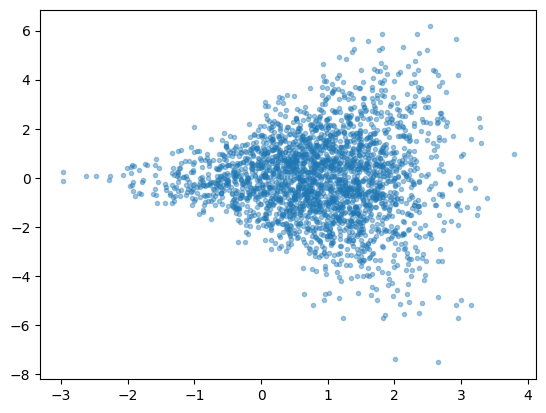

In [7]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

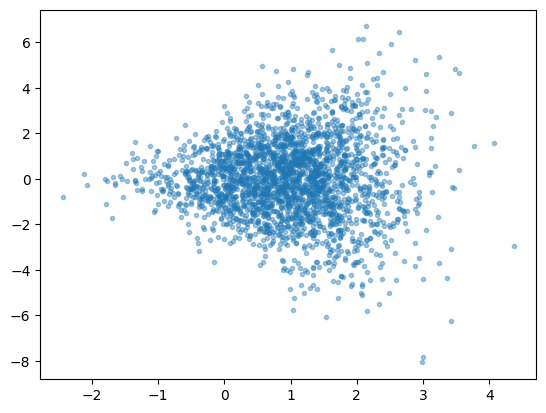

In [8]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [9]:
jnp.array(results_dict["is_eval"]).mean()

DeviceArray(0.19644754, dtype=float32)

In [10]:
results_dict["is_eval"]

[0.34063148498535156,
 0.25713634490966797,
 0.31431007385253906,
 0.48174428939819336,
 0.2250509262084961,
 -1.5691299438476562,
 -0.625788688659668,
 0.42383527755737305,
 0.3949136734008789,
 0.5222592353820801,
 0.3555908203125,
 0.5387654304504395,
 0.4471712112426758,
 0.547816276550293,
 0.4117431640625,
 0.47664880752563477,
 0.25286340713500977,
 0.3381767272949219,
 0.5147247314453125,
 0.3649129867553711,
 0.5430970191955566,
 0.6279191970825195,
 -1.8769855499267578,
 -0.03333616256713867,
 0.6560778617858887,
 0.3731269836425781,
 -0.08646583557128906,
 0.17128658294677734,
 0.22767972946166992,
 0.2776498794555664]

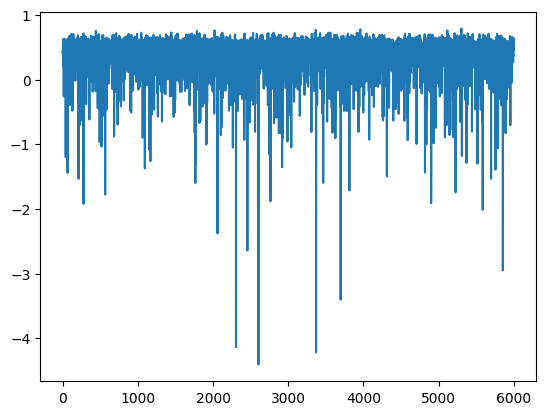

In [11]:
plt.plot(results_dict["is"])

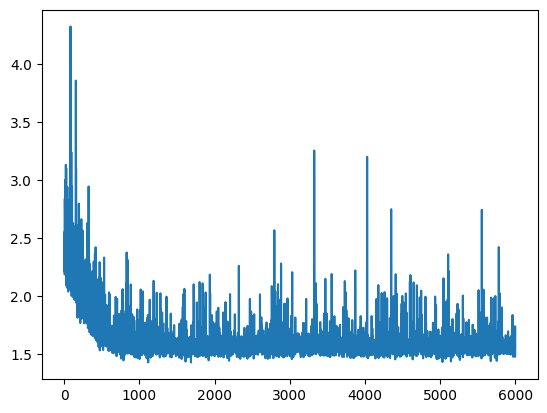

In [12]:
plt.plot(results_dict["elbo"])

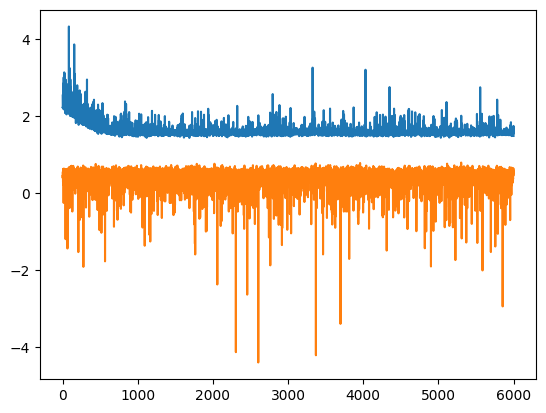

In [13]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])